## Testing 1-dimensional input

In this simple test, we try to fit the cubic function `y = x^3`.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from models.MonotonicNN import MonotonicNN

### Creating the dataset

We first create a dataset of sampled points with a tiny amount of noise.

In [2]:
def cubic_dataset():
    n_samples = 1000
    x = torch.linspace(-1, 1, n_samples) + torch.normal(torch.zeros(n_samples), 0.01)
    x = x.float()[:, None]
    y = x**3 + torch.normal(torch.zeros_like(x), 0.01)
    return x, y

### Generic training loop

basic training loop function, given a dataset. Defaults to Adam with `lr=1e-3`.

In [3]:
def train(model, x, y, batch_size=32, epochs=50):
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        # shuffle dataset
        shuffle = np.arange(len(x))
        np.random.shuffle(shuffle)
        x = x[shuffle]
        y = y[shuffle]
        # iterate over batches
        for b_i in range(0, len(x), batch_size):
            b_x, b_y = x[b_i:b_i+batch_size], y[b_i:b_i+batch_size]
            # predicted output
            y_ = model(b_x)

            opt.zero_grad()
            # simple MSE loss
            loss = F.mse_loss(y_, b_y)
            loss.backward()
            opt.step()
        # print last batch loss
        print(f'epoch \t {epoch}/{epochs}: \t {loss.detach().numpy()}')


### Training the model

We create a model that takes a 1-dimensional input, has a single hidden layer, and outputs the predicted y-value.

epoch 	 0/50: 	 0.04014381021261215
epoch 	 1/50: 	 0.024260183796286583
epoch 	 2/50: 	 0.03394428640604019
epoch 	 3/50: 	 0.019333988428115845
epoch 	 4/50: 	 0.03325255587697029
epoch 	 5/50: 	 0.029372932389378548
epoch 	 6/50: 	 0.02039429545402527
epoch 	 7/50: 	 0.024204060435295105
epoch 	 8/50: 	 0.008277739398181438
epoch 	 9/50: 	 0.010924380272626877
epoch 	 10/50: 	 0.008401099592447281
epoch 	 11/50: 	 0.014000695198774338
epoch 	 12/50: 	 0.008606263436377048
epoch 	 13/50: 	 0.010836501605808735
epoch 	 14/50: 	 0.011720121838152409
epoch 	 15/50: 	 0.006900434847921133
epoch 	 16/50: 	 0.008910681121051311
epoch 	 17/50: 	 0.0062245698645710945
epoch 	 18/50: 	 0.009008973836898804
epoch 	 19/50: 	 0.0069796377792954445
epoch 	 20/50: 	 0.004609599709510803
epoch 	 21/50: 	 0.004339285660535097
epoch 	 22/50: 	 0.0032016788609325886
epoch 	 23/50: 	 0.0016125552356243134
epoch 	 24/50: 	 0.0019316449761390686
epoch 	 25/50: 	 0.0033962386660277843
epoch 	 26/50: 	 0.0

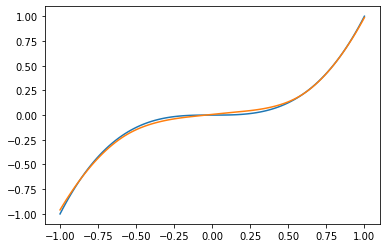

In [4]:
neurons = 32
model = MonotonicNN(1, [neurons], nb_steps=300)
x, y = cubic_dataset()

train(model, x, y)

# test the learnt model
test_x = torch.linspace(-1, 1, 100).float()[:, None]
test_y = test_x**3
with torch.no_grad():
    test_y_ = model(test_x)

plt.figure()
plt.plot(test_x.numpy(), test_y.numpy(), label='ground truth')
plt.plot(test_x.numpy(), test_y_.numpy(), label='learnt MNN')
plt.show()

## Testing 2-dimensional input

Extending to 2-dimensional inputs, trying to learn a monotonically increasing plane. 

In [5]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

from models.MultidimensionnalMonotonicNN import SlowDMonotonicNN

### Creating the dataset

We create an artificial plane as a triangular mesh. We then verify that this plane monotonic by checking, for each point, if the lower-valued coordinates also have lower-valued targets. 

In [6]:
def plane_dataset():
    # the coordinates of each of the triangle vertices
    points = np.array([
        [0, 0, -1], 
        [1,0,0], 
        [0, 1, 0.5], 
        [0.5, 0.5, 0.7], 
        [0.5, 1, 0.8], 
        [1, 0.5, 0.8], 
        [1, 1, 1]])
    # the triangular shapes as a set of 3 vertices, using their indices
    planes = np.array([[0, 1, 3], [0, 2, 3], [1, 3, 5], [2, 3, 4], [3, 4, 5], [4, 5, 6]])
    triangles = points[planes]
    # find the a, b, c, d terms the plane ax + by + cz + d = 0
    ab = triangles[:,1] - triangles[:,0]
    ac = triangles[:,2] - triangles[:,0]
    xyz = np.cross(ab, ac)
    # choose the first vertex of each triangle to find d, using
    # d = -(ax + by + cz)
    d = -np.sum((xyz)*triangles[:,0], -1, keepdims=True)

    # sample (x, y) coordinates, we will then compute the appropriate z-values
    dim = torch.linspace(0, 1, 30)
    grid = torch.meshgrid(dim, dim)
    x = torch.stack(grid, 2).reshape(-1, 2)

    # determine if point is in triangle, see https://stackoverflow.com/a/2049593
    def get_z(x, triangles=triangles):
        triangles = torch.from_numpy(triangles)
        v = ((-x[None]*xyz[:,None,:2]).sum(-1)-d)/xyz[:,[2]]
        v = v.T
        sign = lambda p1, p2, p3: (p1[...,0] - p3[...,0]) * (p2[...,1] - p3[...,1]) - (p2[...,0] - p3[...,0]) * (p1[...,1] - p3[...,1])
        
        y = []
        for pt, z in zip(x, v):
            d1 = sign(pt, triangles[:,0], triangles[:,1])
            d2 = sign(pt, triangles[:,1], triangles[:,2])
            d3 = sign(pt, triangles[:,2], triangles[:,0])

            has_neg = torch.stack((d1 < 0, d2 < 0, d3 < 0), 1).any(1)
            has_pos = torch.stack((d1 > 0, d2 > 0, d3 > 0), 1).any(1)
            
            in_plane = torch.logical_not(torch.logical_and(has_neg, has_pos))
            # if point is on multiple trianges (aka on the edge), simply choose the first one
            chosen_plane = torch.where(in_plane)[0][0]
            y.append(z[chosen_plane])
        return torch.tensor(y, dtype=torch.float32)[:, None]

    y = get_z(x)
    return x, y



/home/mreymond/.local/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-7-85973ea64020>:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  grid = x.reshape(dim, dim, 2).T
<ipython-input-7-85973ea64020>:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used 

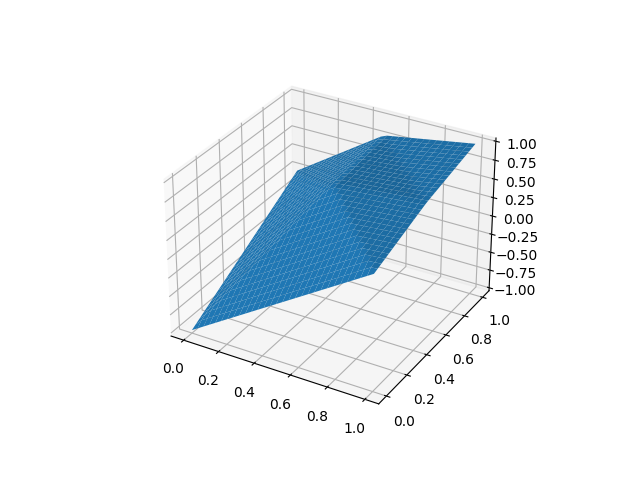

In [7]:
# let's see what it looks like
x, y = plane_dataset()
dim = int(np.sqrt(x.shape[0]))
grid = x.reshape(dim, dim, 2).T
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(grid[0].numpy(), grid[1].numpy(), y.reshape(dim, dim).numpy())
plt.show()

In [8]:
# for each point, we will check dominated points (with lower coordinates),
# these dominated points should have a lower target value
def is_monotonic(x, y):
    x, y, = x.numpy(), y.numpy()
    for x_i ,y_i in zip(x, y):
        # all points with lower x-y values should have a lower z-value
        dominated_i = np.all(x <= x_i, axis=1)
        if not np.all(y[dominated_i] <= y_i):
            print('='*10)
            higher_i = np.argmax(y[dominated_i])
            print(f'x: {x_i} \t y: {y_i} dominated by: {x[higher_i]}, {y[higher_i]}')
            return False
    return True

# verify that the plane is monotonic.
x, y = plane_dataset()
is_monotonic(x, y)

True

### Training the model
We test ouf the MultiDimensional-MNN, with no conditioning variables

epoch 	 0/10: 	 0.012959422543644905
epoch 	 1/10: 	 0.3028346598148346
epoch 	 2/10: 	 0.13604265451431274
epoch 	 3/10: 	 0.09865497052669525
epoch 	 4/10: 	 0.06601367145776749
epoch 	 5/10: 	 0.08223288506269455
epoch 	 6/10: 	 0.13928662240505219
epoch 	 7/10: 	 0.14068114757537842
epoch 	 8/10: 	 0.1363402009010315
epoch 	 9/10: 	 0.09681553393602371


<ipython-input-9-f632d694ad68>:15: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


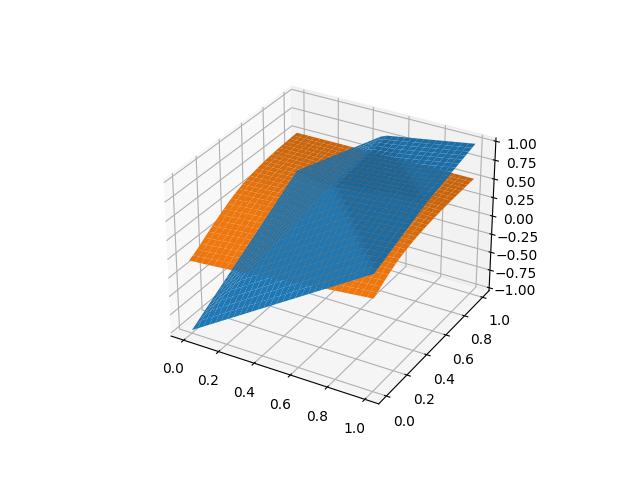

In [9]:
neurons = 64
model = SlowDMonotonicNN(2, 0, [neurons, neurons, neurons], 1, 300, 'cpu')
x, y = plane_dataset()

train(model, x, y, epochs=10)

# test the learnt model
x_test, y_test = plane_dataset()
with torch.no_grad():
    y_test_ = model(x_test)

dim = int(np.sqrt(x_test.shape[0]))
grid = x_test.reshape(dim, dim, 2).T
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(grid[0].numpy(), grid[1].numpy(), y_test.reshape(dim, dim).numpy(), label='ground truth')
ax.plot_surface(grid[0].numpy(), grid[1].numpy(), y_test_.reshape(dim, dim).numpy(), label='learnt MNN')
plt.show()